# Salary prediction

This notebook will be our entry point for our salary prediction study.

It reads the input dataset, performs cleaning and transformation using AUTO libraries for each step, trains a model based on AUTOML, and evaluates its performance.
The core idea is to build a simple but modular pipeline which is flexible enough to incorporate aditional features and models.

##  Table of Contents

1. [Imports and raw data](#imports)  
2. [EDA – Raw Data Check](#eda-raw)  
3. [EDA – Visual Exploration](#eda-visual)  
4. [Preprocessing](#preprocessing)  
5. [Feature Transformation](#features)  
6. [Model Training & Evaluation](#model)
7. [Predicting on New Input Data](#7-predicting-on-new-input-data)

###  1. Imports

All core libraries (Pandas, NumPy, Seaborn...) and our own modular code from `src/`.

We will identify each version of each lbrary in order to generate the requirements for the API.

In [67]:
from pathlib import Path
import sys, os

project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

print(sys.path[:3])
print(os.listdir(project_root / "src/eda"))

['C:\\Users\\leona\\source\\repos\\fau_predic_salario', 'C:\\Users\\leona\\source\\repos\\fau_predic_salario', 'c:\\Users\\leona\\source\\repos\\fau_predic_salario']
['eda.py', '__init__.py', '__pycache__']


In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np

# Scientific computing & ML libraries
from scipy.stats import ttest_ind

#EDA
from src.eda.eda import (merge_multiple_dataframes, 
                        missing_data_table,
                        percentage_rows_missing_data,
                        plot_distributions,
                        count_rows_with_any_null,
                        print_df_overview,
                        count_job_titles,
                        plot_salary_by_gender,
                        gender_salary_stats,
                        plot_kde_salary_by_gender)

#Utils
from src.utils.utils import (plot_numeric_feature_vs_target,
                             plot_categorical_feature_vs_target)
from src.utils.visualizations import boxplots, scatterplot, create_plots, plot_shap_feature_importance, plot_shap_feature_importance_no_embeddings

#Images
from IPython.display import display, Image, Markdown, HTML

###  2. EDA – Raw Data Check

Perform exploratory data analysis. In this case each dataset was separated with the intention to be merged and with that perform the particular analysis.

Before running the pipeline, we quickly review the raw data for:
- Consistency between the two CSV files (people & salary & descriptions)
- Null values
- General data structure

This is optional but helps ensure the data looks clean enough to proceed.

#### Descriptive Analysis

In [69]:
df_people      = pd.read_csv("../data/people.csv")
df_descriptions = pd.read_csv("../data/descriptions.csv")
df_salary      = pd.read_csv("../data/salary.csv")

In [70]:
df_descriptions.head()

,id,Description
0,0,I am a 32-year-old male working as a Software ...
1,1,I am a 28-year-old data analyst with a Master'...
2,2,I am a 45-year-old Senior Manager with a PhD a...
3,3,I am a 36-year-old female Sales Associate with...
4,4,I am a 52-year-old male with over two decades ...


In [71]:
df_descriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           375 non-null    int64 
 1   Description  372 non-null    object
dtypes: int64(1), object(1)
memory usage: 6.0+ KB


This dataset contains descriptions summaries of 375 individuals. Each entry includes a unique ID and a short, free-text description. The descriptions usually mention the person's age, gender, job title, level of education, and sometimes their work experience. For example, a typical entry might read: "I am a 28-year-old data analyst with a Master's degree in Economics."

There are a few missing descriptions—specifically, 3 out of the 375 entries don't have any text in the description field.

In [72]:
df_people.head()

,id,Age,Gender,Education Level,Job Title,Years of Experience
0,0,32.0,Male,Bachelor's,Software Engineer,5.0
1,1,28.0,Female,Master's,Data Analyst,3.0
2,2,45.0,Male,PhD,Senior Manager,15.0
3,3,36.0,Female,Bachelor's,Sales Associate,7.0
4,4,52.0,Male,Master's,Director,20.0


In [73]:
df_people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   375 non-null    int64  
 1   Age                  370 non-null    float64
 2   Gender               370 non-null    object 
 3   Education Level      370 non-null    object 
 4   Job Title            370 non-null    object 
 5   Years of Experience  373 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 17.7+ KB


In [74]:
df_people.describe()

,id,Age,Years of Experience
count,375.000000,370.000000,373.000000
mean,187.000000,37.437838,10.030831
std,108.397417,7.080465,6.557007
min,0.000000,23.000000,0.000000
25%,93.500000,31.250000,4.000000
50%,187.000000,36.000000,9.000000
75%,280.500000,44.000000,15.000000
max,374.000000,53.000000,25.000000


This dataset includes structured demographic and professional information for 375 individuals. Each person is identified by a unique ID and has associated data on age, gender, education level, job title, and years of work experience.

The majority of the records are complete, but a few entries have missing values—specifically, five are missing age, gender, education, or job title, and two are missing years of experience.

Age ranges from 23 to 53, with an average around 37.

Years of Experience varies between 0 and 25 years, with a median of about 9.

Job titles include roles like Software Engineer, Data Analyst, Senior Manager, and Director.

Education levels range from Bachelor’s to PhD.

In [75]:
df_salary.head()

,id,Salary
0,0,90000.0
1,1,65000.0
2,2,150000.0
3,3,60000.0
4,4,200000.0


In [76]:
df_salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      375 non-null    int64  
 1   Salary  373 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 6.0 KB


This dataset contains salary information for 375 individuals, each matched by a unique ID. The salary figures are numerical and represent annual income in dollars.

Most entries have a valid salary, though two records are missing this value. Salaries in the dataset vary widely, ranging from entry-level earnings to high-paying executive positions—examples include 60,000 for a Sales Associate and up to $200,000 for a Director-level role.

This data is intended to be combined with demographic and job-related information from the other datasets for a more complete analysis.

#### Merge datasets

In [77]:
# Dataset paths
file_paths = ['../data/descriptions.csv', '../data/people.csv', '../data/salary.csv']
# Merging datasets using EDA function
df_merged = merge_multiple_dataframes(file_paths, 'id')

df_merged.head()

,id,Description,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,0,I am a 32-year-old male working as a Software ...,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,1,I am a 28-year-old data analyst with a Master'...,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,2,I am a 45-year-old Senior Manager with a PhD a...,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,3,I am a 36-year-old female Sales Associate with...,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,4,I am a 52-year-old male with over two decades ...,52.0,Male,Master's,Director,20.0,200000.0


#### Missing Values

We’ve already noticed some missing values across the individual datasets. Now that we’ve merged them, it’s time to take a closer look at these gaps and decide how best to handle them.

After merging, we might find that a row missing data in one dataset has useful information in another. Now, we coudl drop the row with missing values or maybe fill in the missing values.

A good starting point is to assess how many rows contain missing data across the entire merged dataset. A common rule of thumb in data analysis is tha dropping less than 5% of the dataset is generally considered safe.

Losing a small fraction (e.g., <5%) usually won’t significantly impact the analysis or model performance—especially if the missing data is random. In fact, dropping these rows can often be safer than filling them with potentially misleading values.

Why be cautious with imputation?

- Filling in age with a mean or median may not reflect the actual distribution and could misrepresent the data.
- Filling in salary with an average can distort the income distribution and lead to incorrect assumptions.

Therefore, when the missing data:

- Is **random** (i.e., not concentrated in a specific group),
- Represents a **small portion** of the dataset, and
- Comes from a **sufficiently large sample**,

then dropping the affected rows is often the simplest and most reliable approach.

In [78]:
missing_data_table(df_merged)

,NaN Count,NaN Percentage (%)
id,0,0.00
Description,3,0.80
Age,5,1.33
Gender,5,1.33
Education Level,5,1.33
Job Title,5,1.33
Years of Experience,2,0.53
Salary,2,0.53


In [79]:
percentage = percentage_rows_missing_data(df_merged)
print(f"Percentage of rows with at least one missing value: {percentage:.2f}%")

Percentage of rows with at least one missing value: 4.53%


We see that the overall Percentage of rows with at least one missing value is slightly lower than 5%.

Now, let's check if the missing data is random or has a pattern. We'll do that with two graphs:

- Matrix: shows where missing values are. Each column represents a variable and each row represents a person (or entry in the dataset). The white bars show where the missing data is.

- Heatmap: helps you see if missing values tend to happen together. This heatmap does not show the correlation of the actual values, but the correlation between the missing data.

In [80]:
display(HTML("""
<figure>
  <img src="../images/ydata_alerts.png" style="width:75%; height:75%;" />
  <figcaption style="text-align:left;"><strong>Image 1:</strong> EDA YData profilling - Alerts</figcaption>
</figure>
"""))

We see that the overall Percentage of rows with at least one missing value is slightly lower than 5%.

Now, let's check if the missing data is random or has a pattern. We'll do that with two graphs:

- Matrix: shows where missing values are. Each column represents a variable and each row represents a person (or entry in the dataset). The white bars show where the missing data is.

- Heatmap: helps you see if missing values tend to happen together. This heatmap does not show the correlation of the actual values, but the correlation between the missing data.

We obtain some analysis from ydata profilling in order to explain null values but it is the same to execute the code below.

In [81]:
display(HTML("""
<figure>
  <img src="../images/nulls_matrix_eda.png" style="width:75%; height:75%;" />
  <figcaption style="text-align:left;"><strong>Image 2:</strong> EDA YData profilling - Missing values</figcaption>
</figure>
"""))

In [82]:
display(HTML("""
<figure>
  <img src="../images/nulls_heatmap_eda.png" style="width:75%; height:75%;" />
  <figcaption style="text-align:left;"><strong>Image 3:</strong> EDA YData profilling - Missing values</figcaption>
</figure>
"""))

c:\Users\leona\anaconda3\envs\funda_apre_auto\lib\site-packages\missingno\missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


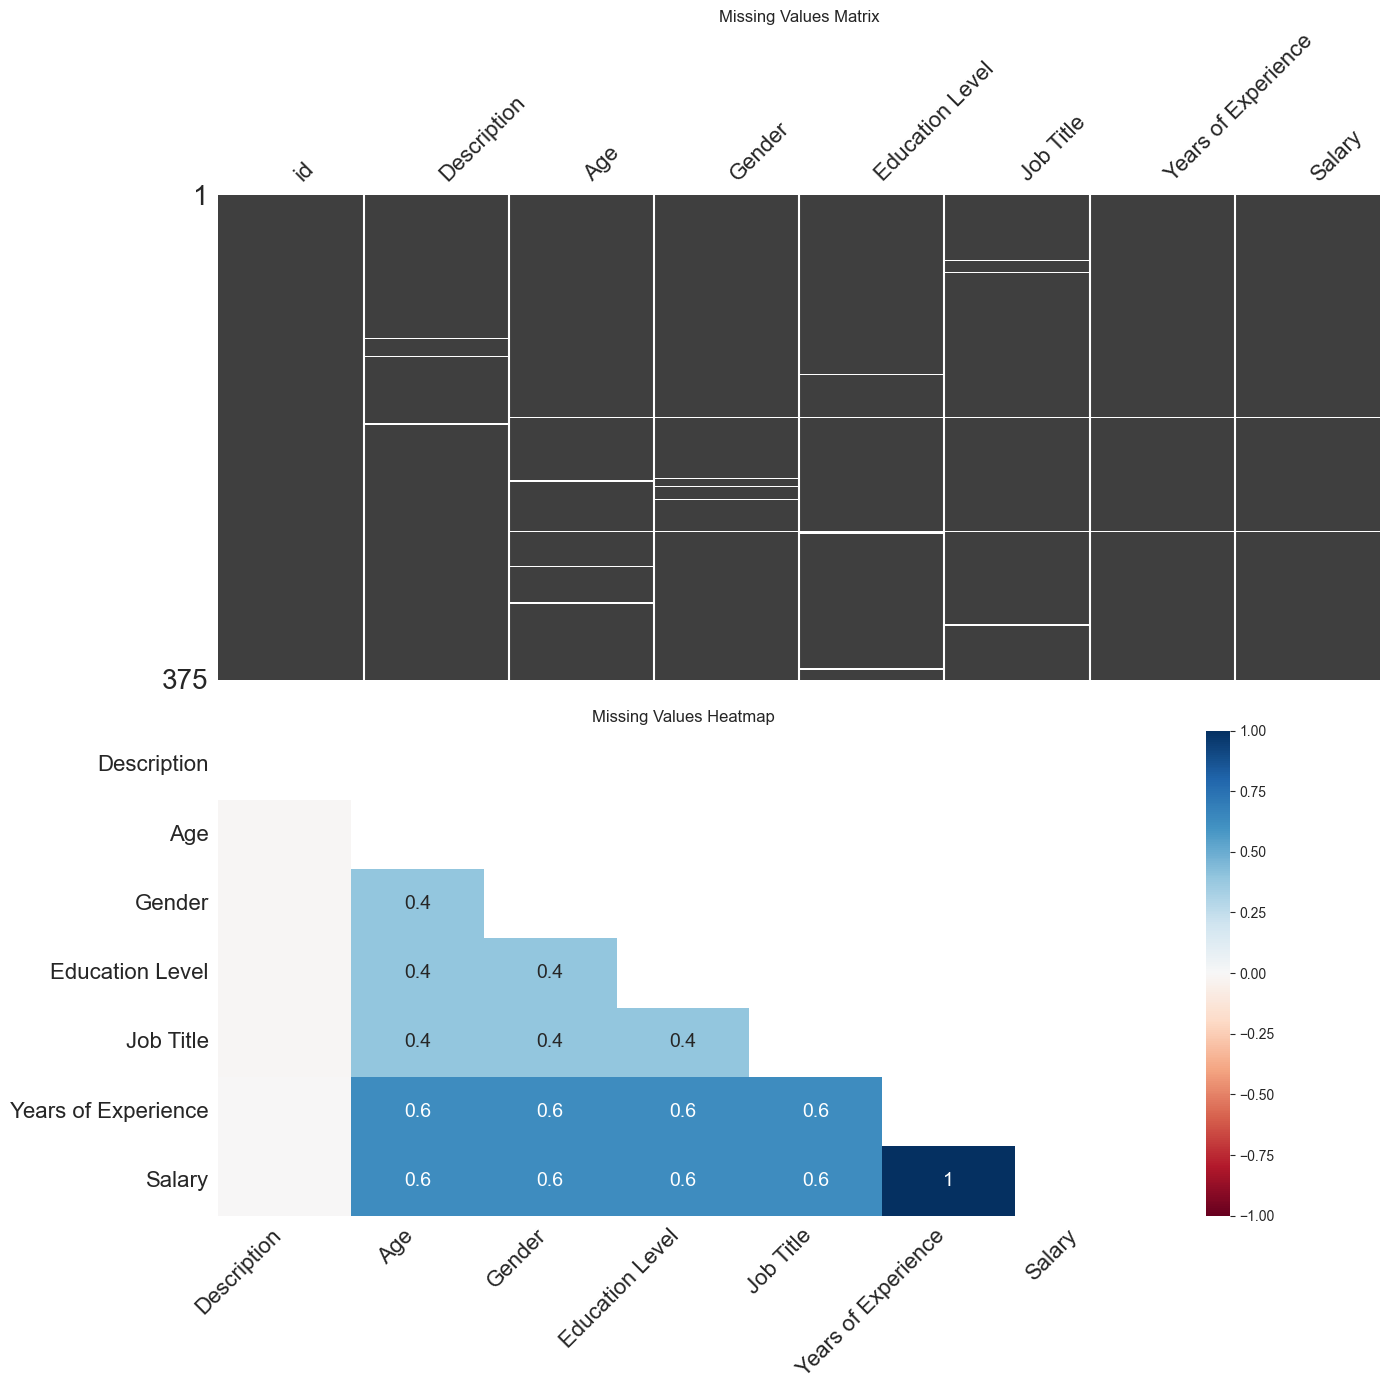

In [83]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(2, 1, figsize=(14, 14))

# Plot missing values matrix on the first subplot
msno.matrix(df_merged, ax=axes[0])
axes[0].set_title("Missing Values Matrix")

# Plot missing values heatmap on the second subplot
msno.heatmap(df_merged, ax=axes[1])
axes[1].set_title("Missing Values Heatmap")

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

**Missing values Matrix (Image 1)**  
This visualization provides a clear overview of missing data across both rows and columns. We can see that:

- Missing values appear to be sporadically distributed, with no strong concentration in any specific row or group.
- A few columns — notably **Age**, **Gender**, **Education Level**, **Job Title**, and **Description** — show minor patches of missing data.
- There’s no evidence of a systemic pattern (e.g., no subset of records consistently missing multiple fields).

The missingness appears to be **random and low in volume**, making it reasonable to proceed with dropping these rows. This approach is unlikely to introduce significant bias or affect overall data integrity.

**Missing values heatmap (Image 2)**

This shows how missingness in columns correlates with each other:
- Lighter colors indicate low or no correlation between missing values across columns.

The only notable relationship is between Salary and Years of Experience: they share a high correlation (1).

This suggests that people missing Salary are also be missing Experience — maybe new workers or entries with incomplete profiles (they are perfectly correlated in terms of absence, not in terms of their actual numerical values).

However, Salary is the target value and rows that are missing this value are not useful for training or evaluating predictive models.

Keeping these rows could introduce noise or skew analysis like correlations or distributions.

In [84]:
# Count and display rows that have at least one null value
count_rows_with_any_null(df_merged, name="merged df")


 amount of rows that have at least a NaN value: 17
      id                                        Description   Age  Gender  \
51    51  I am a 33-year-old Business Intelligence Analy...  33.0    Male   
60    60  I am a 51-year-old female with a Master's degr...  51.0  Female   
111  111                                                NaN  37.0    Male   
125  125                                                NaN  26.0    Male   
139  139  I am a 43-year-old Senior Product Marketing Ma...  43.0  Female   
172  172  As an employee, I bring a wealth of diverse ex...   NaN     NaN   
177  177                                                NaN  31.0    Male   
219  219  I am a 40-year-old Senior Sales Representative...  40.0     NaN   
221  221  I am a 31-year-old female currently working as...   NaN  Female   
225  225  I am a 40-year-old Senior Marketing Manager wi...  40.0     NaN   
235  235  As a 32-year-old Junior Sales Representative w...  32.0     NaN   
260  260  As an employee

@leandro-biderman @msambrizzi-austral escribir una reseña o conclusión de lo arriba descripto si es que aplica

In [85]:
#Print shape, types and head of the merged dataset
print_df_overview(df_merged, name="merged df")


 dtype:
id                       int64
Description             object
Age                    float64
Gender                  object
Education Level         object
Job Title               object
Years of Experience    float64
Salary                 float64
dtype: object


Taking all these into account, we will drop rows with NaN values on the dataframe.

In [86]:
df_merged = df_merged.dropna()

In [87]:
missing_data_table(df_merged)

,NaN Count,NaN Percentage (%)
id,0,0.0
Description,0,0.0
Age,0,0.0
Gender,0,0.0
Education Level,0,0.0
Job Title,0,0.0
Years of Experience,0,0.0
Salary,0,0.0


###  3. EDA – Visual Exploration

We are going to visualize each important column of our dataset in order to determinate if we need to perfomr any type of transformation or generate a new field utilizing the column we have, with the intention of generate more columns that contibute to our models we are going to use.

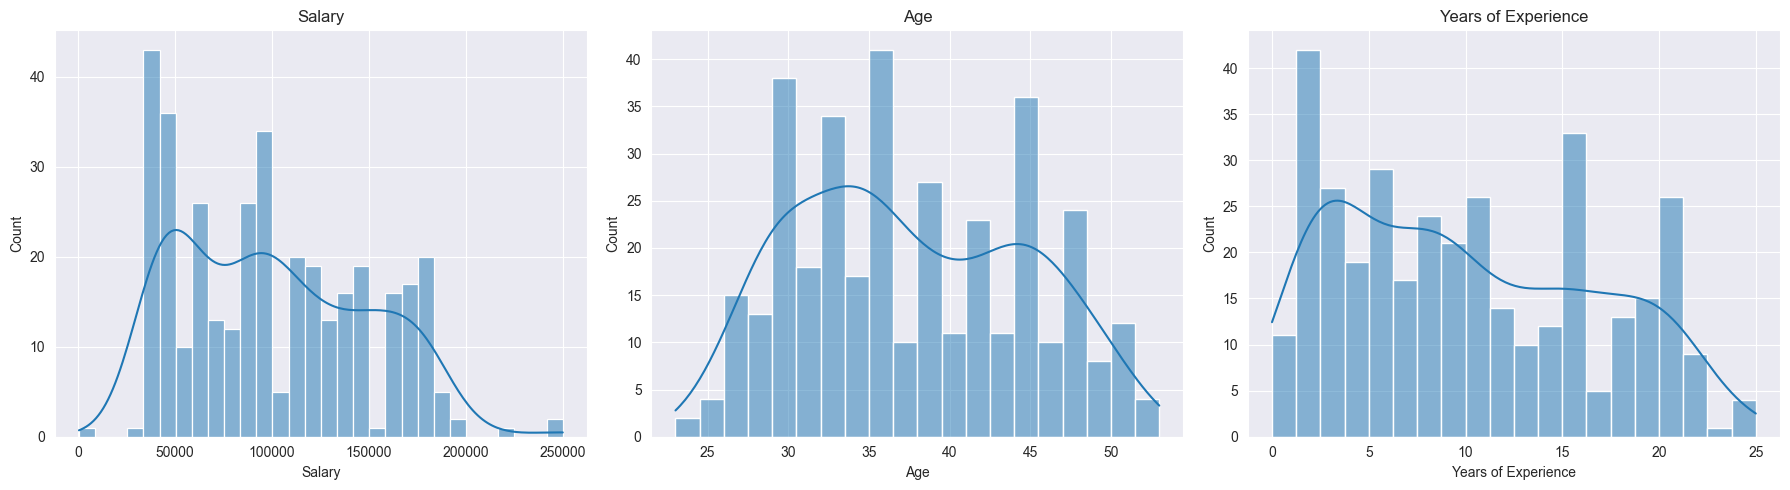

In [88]:
plot_distributions(df_merged)


#### Distribution of numerical columns

##### **Age**
- The distribution is slightly right-skewed, but generally well-balanced.
- Most individuals fall between 30 and 45 years old, with a peak around the early 30s. This suggests the dataset includes a significant number of early- to mid-career professionals.
- There's a drop-off after age 50, and only a small number of entries under 25. That aligns with typical workforce demographics, where fewer very young or senior-aged professionals are present.
- This distribution seems fairly representative for industries that rely on some level of experience, though it might underrepresent entry-level or late-career professionals.

##### **Years of Experience**
- This distribution is noticeably right-skewed, with a heavy concentration in the lower range (0–10 years).
- There's a sharp peak at around 2–5 years, suggesting a large portion of the dataset includes people early in their careers.
- Beyond 15 years, the number of individuals tapers off significantly, and there are very few with more than 20 years of experience.
- This pattern likely reflects a workforce with many junior to mid-level professionals and a relatively smaller number of senior experts.
- It's also worth noting the potential for overlap between very young ages and missing experience values — this could indicate interns, students, or newly hired workers with incomplete data.

##### **Salary**
- Salary is the most skewed of the three distributions — there's a long right tail, indicating a smaller number of high earners.
- Most salaries cluster between 30,000 and 150,000, with common peaks around 50K–70K and another noticeable bump closer to 100K.
- A few entries go beyond $200,000, but these are outliers. Depending on the context of the dataset (e.g., tech, finance), these could represent executives, specialists, or outlier roles.
- This distribution might benefit from a transformation before modeling, especially if we’re using algorithms sensitive to skewed distributions.
- Since Salary is the target variable, understanding its shape helps inform how we deal with both missing values and potential outliers.

**Summary**
- These distributions give us a clearer picture of the population: largely early- to mid-career professionals with moderate salaries and limited long-term experience.
- Before modeling, we may want to:
  - **Explore correlations** between Age, Experience, and Salary.
  - **Segment by role or education** to better understand how these factors interact across groups.

@leandro-biderman @msambrizzi-austral pls revisen estos textos y que al menos concluyan lo mismo :D

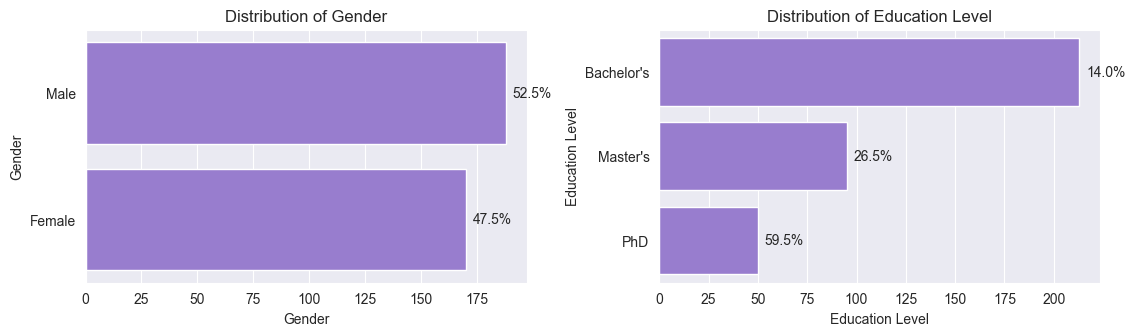

In [89]:
# Select only categorical columns
categorical_cols = df_merged.select_dtypes(include=['object']).columns

# Plot categorical features (bar chart)
categorical_cols_for_graph = categorical_cols.drop(['Description', 'Job Title'], errors='ignore')
create_plots(
    categorical_cols_for_graph,
    lambda col, ax: (
        sns.countplot(y=col, data=df_merged, ax=ax, color="mediumpurple"),
        ax.bar_label(
            ax.containers[0],
            labels=[
                f'{(v / df_merged[col].notna().sum() * 100):.1f}%'
                for v in df_merged[col].value_counts().sort_index(ascending=False).values
            ],
            padding=5,
            fontsize=10
        )
    ),
    n_cols=2,
)

#### Distribution of categorical columns

##### **Gender**
- The gender distribution is fairly balanced, with:
  - 52.5% Male
  - 47.5% Female
- This slight male majority suggests no major gender imbalance, which is great from a modeling perspective—it reduces the risk of gender-related bias.

##### **Education Level**
- Education level is a bit more skewed, with the majority of individuals holding a Bachelor’s degree (59.5%).
- This is followed by:
  - Master’s degrees at 26.5%
  - PhDs at 14%
- The dominance of Bachelor’s degrees suggests the dataset leans toward entry-level or general professional roles rather than academic or specialized research positions.
- The fairly strong presence of advanced degrees (40.5% have a Master’s or PhD) still indicates a well-educated population, which might influence things like salary expectations or job responsibilities.

**Summary**
- **Gender** is close to evenly split, with a small male majority.
- **Education** is skewed toward Bachelor’s degrees, but there’s a strong representation of postgraduate qualifications.

@leandro-biderman @msambrizzi-austral pls revisen estos textos y que al menos concluyan lo mismo :D

In [90]:
# Count and display the number of unique job titles with more than 6 occurrences
count_job_titles(df_merged, threshold=6)


 Amount of rows with job titles that appear more than 6 times: 84
 Job Titles with more than 6 repetitions:
Job Title
Director of Marketing                    12
Director of Operations                   10
Senior Business Analyst                  10
Junior Business Analyst                   8
Senior Marketing Analyst                  8
Senior Marketing Manager                  8
Senior Data Scientist                     7
Senior Project Manager                    7
Junior Business Development Associate     7
Senior Financial Analyst                  7
Name: count, dtype: int64


**Notes on 'Description' and 'Job Title' Columns**

The 'Description' and 'Job Title' columns contain a large number of unique values, which makes them high-cardinality features.

- These fields are text-heavy and unstructured, especially 'Description', which might contain free-form input or role-specific notes.
- 'Job Title', although more structured, still includes a wide variety of titles, often with slight variations (e.g., "Software Engineer", "Software Developer", "Sr. Software Engineer"), which can add complexity when grouping or analyzing them.

Due to this high cardinality, these columns are not ideal for straightforward visualization or encoding without preprocessing. For now, we will be excluding them temporarily from exploratory visualizations, as they don’t lend themselves well to simple bar plots.

But later on, we may consider:
- **Standardizing job titles** (e.g., grouping by role family or level),
- **Extracting features from descriptions** (e.g., NLP techniques)

@leandro-biderman @msambrizzi-austral pls revisen estos textos y que al menos concluyan lo mismo :D

In [91]:
display(HTML("""
<figure>
  <img src="../images/job_title_analysis_1.png" style="width:75%; height:75%;" />
  <figcaption style="text-align:left;"><strong>Image 4:</strong> EDA YData profilling - Job Title</figcaption>
</figure>
"""))

In [92]:
display(HTML("""
<figure>
  <img src="../images/job_title_analysis_2.png" style="width:75%; height:75%;" />
  <figcaption style="text-align:left;"><strong>Image 5:</strong> EDA YData profilling - Job Title Overview</figcaption>
</figure>
"""))

In [93]:
display(HTML("""
<figure>
  <img src="../images/job_title_analysis_3.png" style="width:50%; height:50%;" />
  <figcaption style="text-align:left;"><strong>Image 6:</strong> EDA YData profilling - Job Title disrtibution</figcaption>
</figure>
"""))

Reviewwing the Job Title row we can analyze this:

We conclude from the result of the function "count_job_titles", only 93 records share any of the ten most common job titles (i.e. those appearing more than six times), which underscores a long-tail distribution in our "Job Title" field. The ten most frequent roles are all mid-to-senior level positions—such as Director of Marketing (12), Senior Business Analyst (10), and Director of Operations (10)—but even the top title accounts for just over 1% of the dataset.

This suggests two things for possible feature engineering:

1. High cardinality: most titles appear very rarely, so treating each title as its own category could lead to over-fitting.
2. Need for grouping: you’ll likely want to bucket rare titles into an "Other" category (or by seniority) to reduce noise and improve model stability.

Regarding the graphics we collect from AUTO Eda we can conclude:

1. High cardinality, low missingness:
    There are 173 distinct titles in a dataset of ~370 records (46.8% distinct), with only 5 missing entries (1.3%). This tells us that nearly every professional has a unique or rare title.

2. Length & complexity:
    Titles range from 3 to 37 characters (mean ~22, median ~31), using 47 distinct characters and over 100 unique values. Such long, free‐text strings often carry redundant modifiers (“of”, “and”, etc.) and will benefit from normalization (e.g. lowercasing, stripping stop‐words).

3. Dominant keywords & long tail:
    Words like “senior” (14.4%), “manager” (9.1%), and “junior” (8.6%) are the most frequent tokens, followed by functional terms such as “analyst,” “marketing,” and “director.” Yet 38% of all titles fall into an “Other” category of 74 rarer terms.

Conclusion:
The "Job Title" field exhibits a classic long‐tail distribution with a handful of dominant hierarchical keywords and a very long tail of one-off roles. To make this feature more machine-learning-friendly, we should:

1. Normalize and tokenize (e.g. extract “seniority” and “function” separately).
2. Bucket rare titles into an “Other” group or coarser categories (e.g. seniority levels and department).
3. Optionally apply n-gram or embedding techniques if we want to preserve text nuance while controlling cardinality.

@leandro-biderman @msambrizzi-austral pls revisen estos textos y que al menos concluyan lo mismo :D

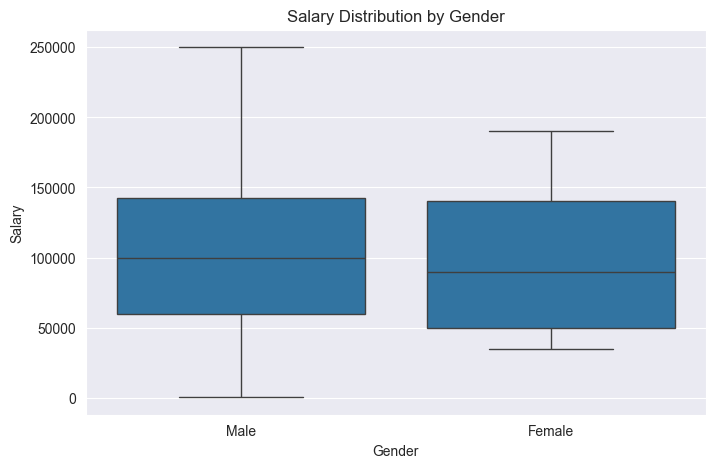

Salary stats by gender:
        count           mean    median
Gender                                
Female    170   96529.411765   90000.0
Male      188  104815.691489  100000.0


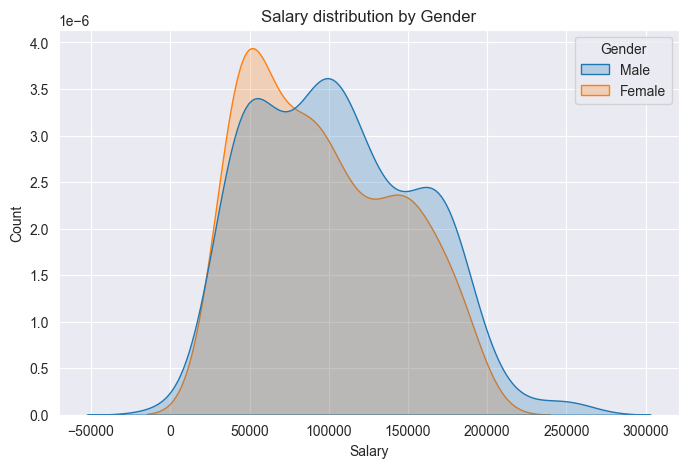

Note: If the KDE appears to go below zero, it is a plotting artifact. Actual density values are not negative.


In [94]:
# Plot relating gender
plot_salary_by_gender(df_merged)
gender_salary_stats(df_merged)
plot_kde_salary_by_gender(df_merged)

In order to analyze salary by gender we show two plots:

1. Boxplot:

   * The median male salary (≈ $100 000) sits above the female median (≈ $90 000).
   * The interquartile range (middle 50 %) for men is shifted upward compared to women, meaning that a typical male salary tends to be higher.
   * Both groups have a similar overall spread and outliers, but the highest‐paid males exceed the highest‐paid females.

2. KDE (Kernel Density Estimate):

   * Both distributions overlap heavily, indicating many shared salary levels.
   * The male curve is slightly right-shifted (peak around $100 000) versus the female peak (around $90 000).
   * The male density has a longer right tail, confirming more high-salary observations.

**Conclusion:**
Together with summary stats (mean male ≈ $104 k vs. female ≈ $97 k), these visuals point to a modest gender pay gap—men earn about $7 k more on average—but also reveal that salary distributions largely coincide between genders. There’s significant overlap, suggesting many roles pay similarly regardless of gender, yet the upper end of the pay scale skews male.

@leandro-biderman @msambrizzi-austral pls revisen estos textos y que al menos concluyan lo mismo :D

An independent t-test (also called a two-sample t-test) is a statistical test used to compare the means of two independent groups to see if there's a statistically significant difference between them.

You use an independent t-test when:

- You have two groups (e.g., Male vs. Female).

- You want to compare their average values for some numeric variable (e.g., Salary).

- The groups are independent (one person can't be in both groups).

If p-value < 0.05 → There is a statistically significant difference in salaries between genders.

If p-value >= 0.05 → There is no significant evidence of a salary difference by gender.

In [95]:
# Filter salary data by gender
male_salaries = df_merged[df_merged['Gender'] == 'Male']['Salary']
female_salaries = df_merged[df_merged['Gender'] == 'Female']['Salary']

# Perform independent t-test
t_stat, p_value = ttest_ind(male_salaries, female_salaries, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

T-statistic: 1.6247
P-value: 0.1051


Since the p-value (0.1051) is greater than 0.05, we do not have sufficient statistical evidence to conclude that there's a significant difference in salary between males and females in your dataset.

In other words, while the boxplot visually suggests that males might earn slightly more on average, the difference is not statistically significant based on this sample.

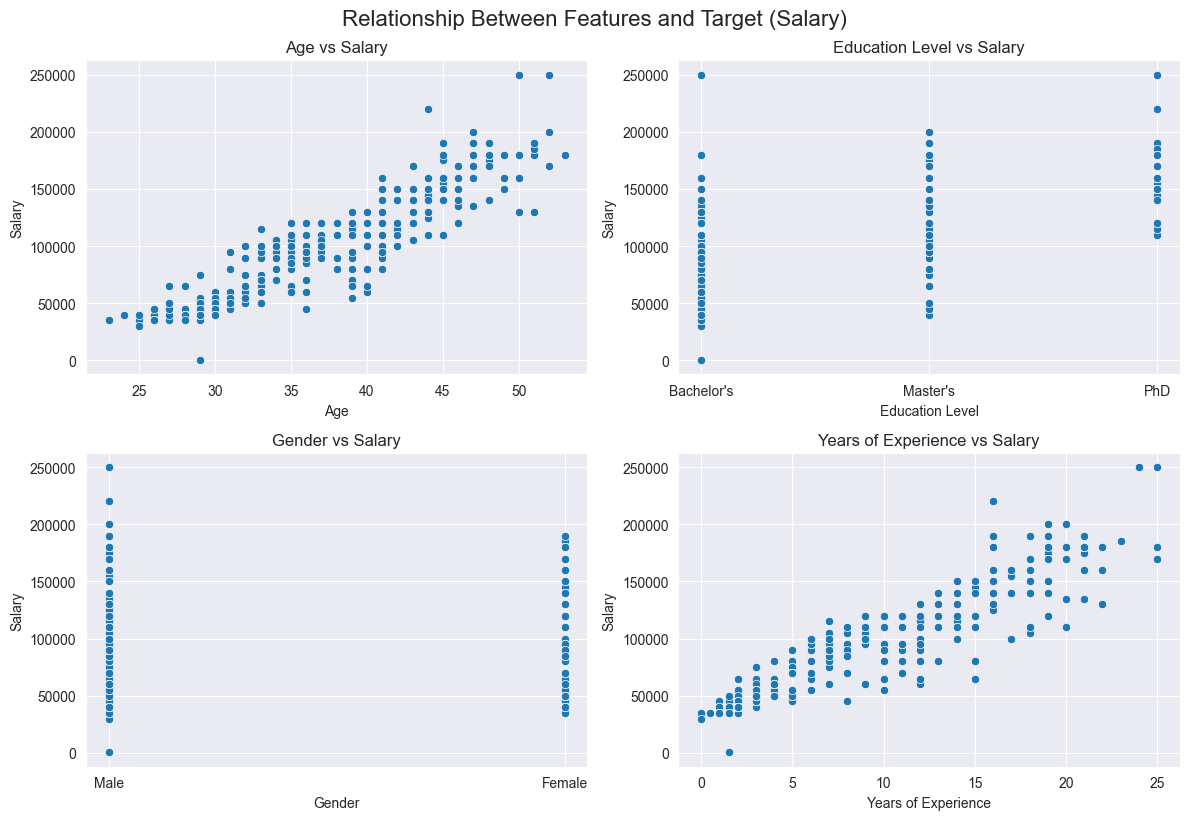

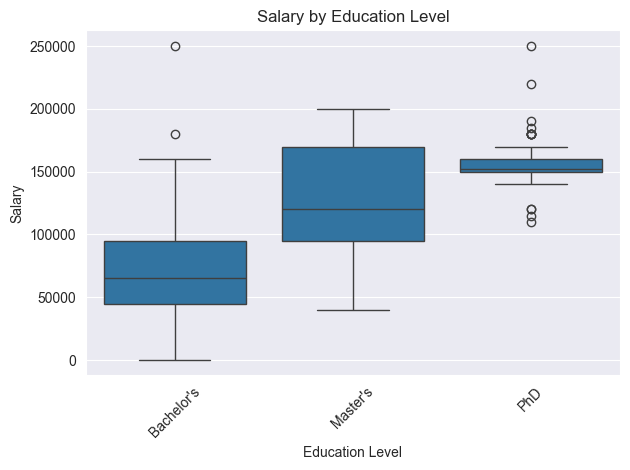

In [96]:
#plot_numeric_feature_vs_target(df_merged, "Years of Experience")
#plot_numeric_feature_vs_target(df_merged, "Age")

scatterplot(df_merged)

plot_categorical_feature_vs_target(df_merged, "Education Level")

To get a sense of how the input features relate to salary, we plotted them against the target (in this case, the actual salary).

1. **Age vs. Salary** *(Top-left)*  
There is a clear positive trend, as age increases, salary tends to increase as well.  
This suggests that older individuals typically earn higher salaries, possibly due to increased experience or seniority.

2. **Gender vs. Salary** *(Top-right)*  
The salary distribution between Male and Female appears relatively similar at first glance.  

3. **Education Level vs. Salary** *(Bottom-left)*  
There seems to be some variation in salary across education levels:
   - Individuals with a PhD often earn more, on average.
   - Those with Bachelor's and Master’s degrees show a wider spread in salaries.

1. **Years of Experience vs. Salary** *(Bottom-right)*  
This feature shows a strong positive relationship with salary, more years of experience are generally associated with higher earnings.  
This is likely one of the most influential variables in determining salary.

1. **Education Level vs. Salary**
The boxplot shows some differences. people with a PhD usually earn more, and the salaries are more consistent. Master's is a bit more spread out but still higher than Bachelor's. So education level seems useful, though there’s overlap.

In short, the plots confirm that experience is the most solid predictor, and that age and education also help, at least to some degree.

@leandro-biderman @msambrizzi-austral podremos poner conclusiones por cada gráfico? se pueden copiar los que otuvimos del EDA automático, igualmente en ambos les falta una explicación de que se visualiza.

#### Outliers

In [97]:
df_merged.describe()

,id,Age,Years of Experience,Salary
count,358.000000,358.000000,358.000000,358.000000
mean,185.946927,37.446927,10.065642,100880.865922
std,109.122371,7.090944,6.588486,48512.245167
min,0.000000,23.000000,0.000000,350.000000
25%,91.250000,31.250000,4.000000,55000.000000
50%,185.500000,36.000000,9.000000,95000.000000
75%,280.750000,44.000000,15.750000,140000.000000
max,374.000000,53.000000,25.000000,250000.000000


Select numerical and categorical columns

In [98]:
# Select only numerical columns
numerical_cols = df_merged.select_dtypes(include=np.number).columns
# Drop the 'id' column
numerical_cols = numerical_cols.drop('id', errors='ignore')

# Select only categorical columns
categorical_cols = df_merged.select_dtypes(include=['object']).columns

We will use boxplots to visually detect any presence of outliers

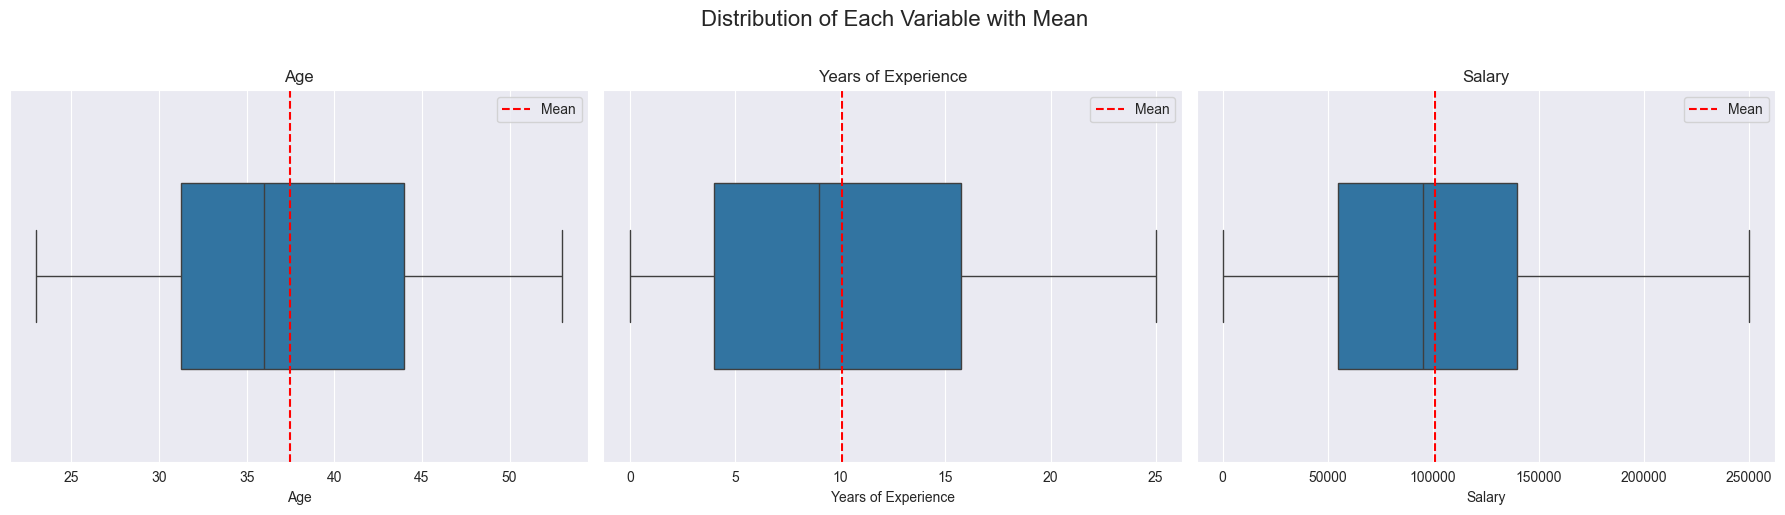

In [99]:
boxplots(df_merged, numerical_cols)

We did not notice outliers in the numerical columns.

@leandro-biderman @msambrizzi-austral pls agregar mas texto de ser posible :D

#### Correlation matrix

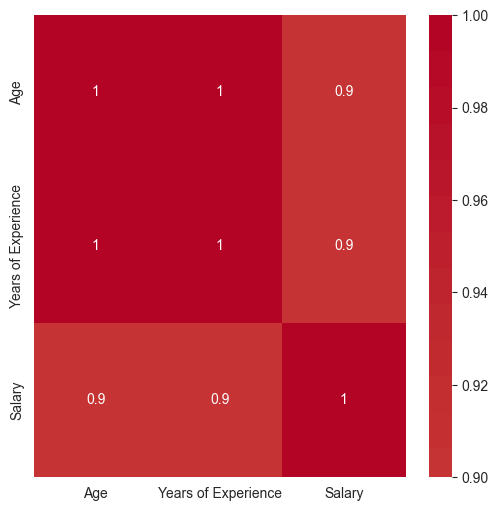

In [100]:
corr = df_merged[numerical_cols].corr().round(1)
plt.figure(figsize=(6, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.show()

In [101]:
display(HTML("""
<figure>
  <img src="../images/associations_SWEETVIZ.png" style="width:50%; height:50%;" />
  <figcaption style="text-align:left;"><strong>Image 7:</strong> EDA SWEETVIZ - Associations</figcaption>
</figure>
"""))

## AutoViz

In [15]:
import matplotlib
print(f'Matplotlib version: {matplotlib.__version__}')

Matplotlib version: 3.9.4


In [16]:
from autoviz.AutoViz_Class import AutoViz_Class

In [17]:
AV = AutoViz_Class()

## Pandas Profiling

In [8]:
import pandas as pd

# Cargar los archivos CSV
descriptions = pd.read_csv('./data/descriptions.csv')
people = pd.read_csv('./data/people.csv')
salary = pd.read_csv('./data/salary.csv')

# Unir los datasets utilizando el campo 'id'
merged_df = people.merge(descriptions, on='id').merge(salary, on='id')

# Mostrar las primeras filas del dataset combinado


Shape of your Data Set loaded: (375, 8)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    Number of Numeric Columns =  3
    Number of Integer-Categorical Columns =  0
    Number of String-Categorical Columns =  1
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  1
    Number of Numeric-Boolean Columns =  0
    Number of Discrete String Columns =  1
    Number of NLP String Columns =  1
    Number of Date Time Columns =  0
    Number of ID Columns =  1
    Number of Columns to Delete =  0
    8 Predictors classified...
        1 variable(s) removed since they were ID or low-information variables
        List of variables removed: ['id']
To fix these data quality issues in the dataset, import FixDQ fr

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
id,int64,0.000000,100,0.000000,374.000000,Possible ID column: drop before modeling step.
Age,float64,1.333333,NA,23.000000,53.000000,"5 missing values. Impute them with mean, median, mode, or a constant value such as 123."
Gender,object,1.333333,0,,,"5 missing values. Impute them with mean, median, mode, or a constant value such as 123., Mixed dtypes: has 2 different data types: object, float,"
Education Level,object,1.333333,0,,,"5 missing values. Impute them with mean, median, mode, or a constant value such as 123., Mixed dtypes: has 2 different data types: object, float,"
Job Title,object,1.333333,46,,,"5 missing values. Impute them with mean, median, mode, or a constant value such as 123., Mixed dtypes: has 2 different data types: object, float,, Possible high cardinality column with 173 unique values: Use hash encoding or text embedding to reduce dimension."
Years of Experience,float64,0.533333,NA,0.000000,25.000000,"2 missing values. Impute them with mean, median, mode, or a constant value such as 123., Column has a high correlation with ['Age']. Consider dropping one of them."
Description,object,0.800000,99,,,"3 missing values. Impute them with mean, median, mode, or a constant value such as 123., Mixed dtypes: has 2 different data types: object, float,"
Salary,float64,0.533333,NA,350.000000,250000.000000,"2 missing values. Impute them with mean, median, mode, or a constant value such as 123., Column has a high correlation with ['Age', 'Years of Experience']. Consider dropping one of them."


Number of All Scatter Plots = 6


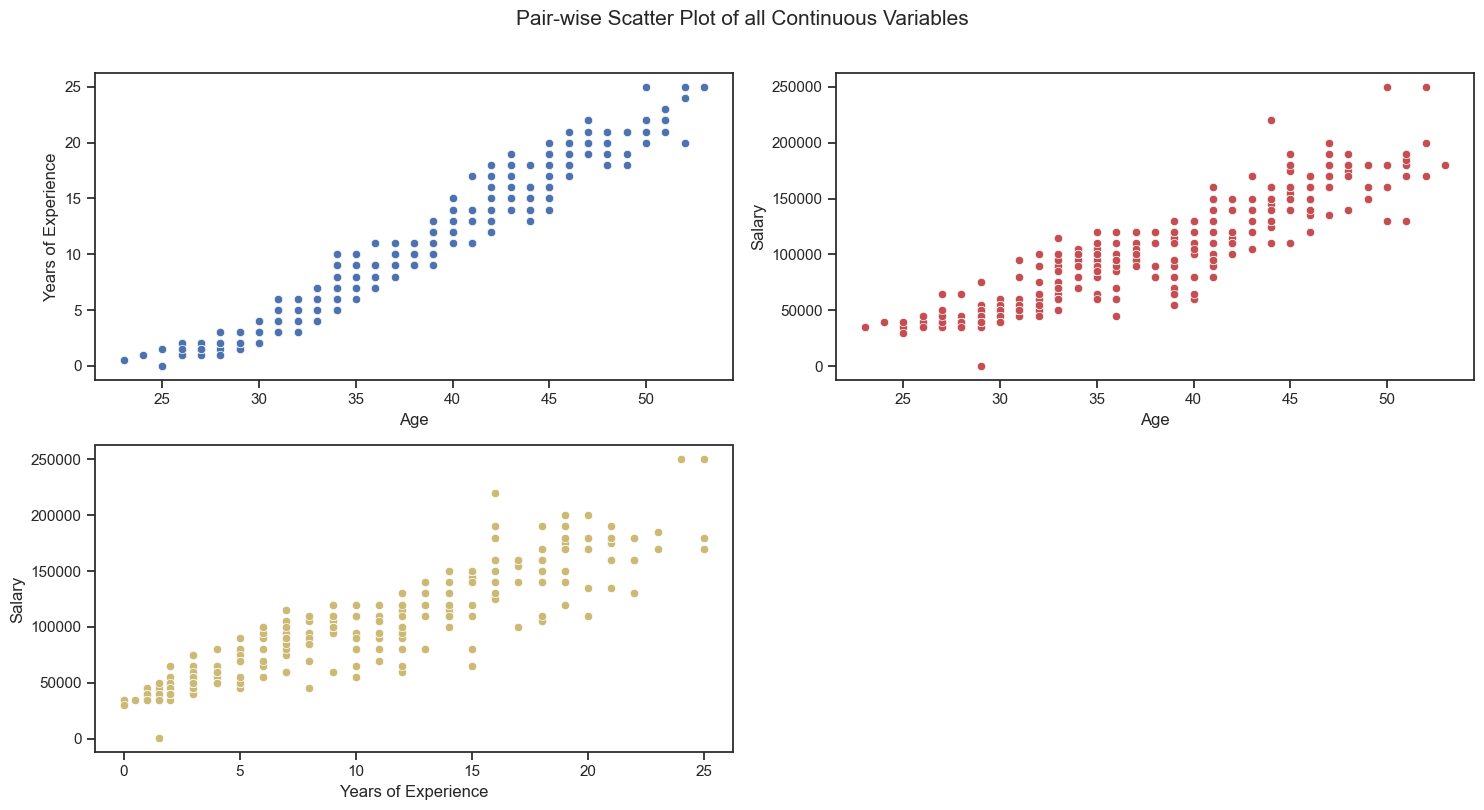

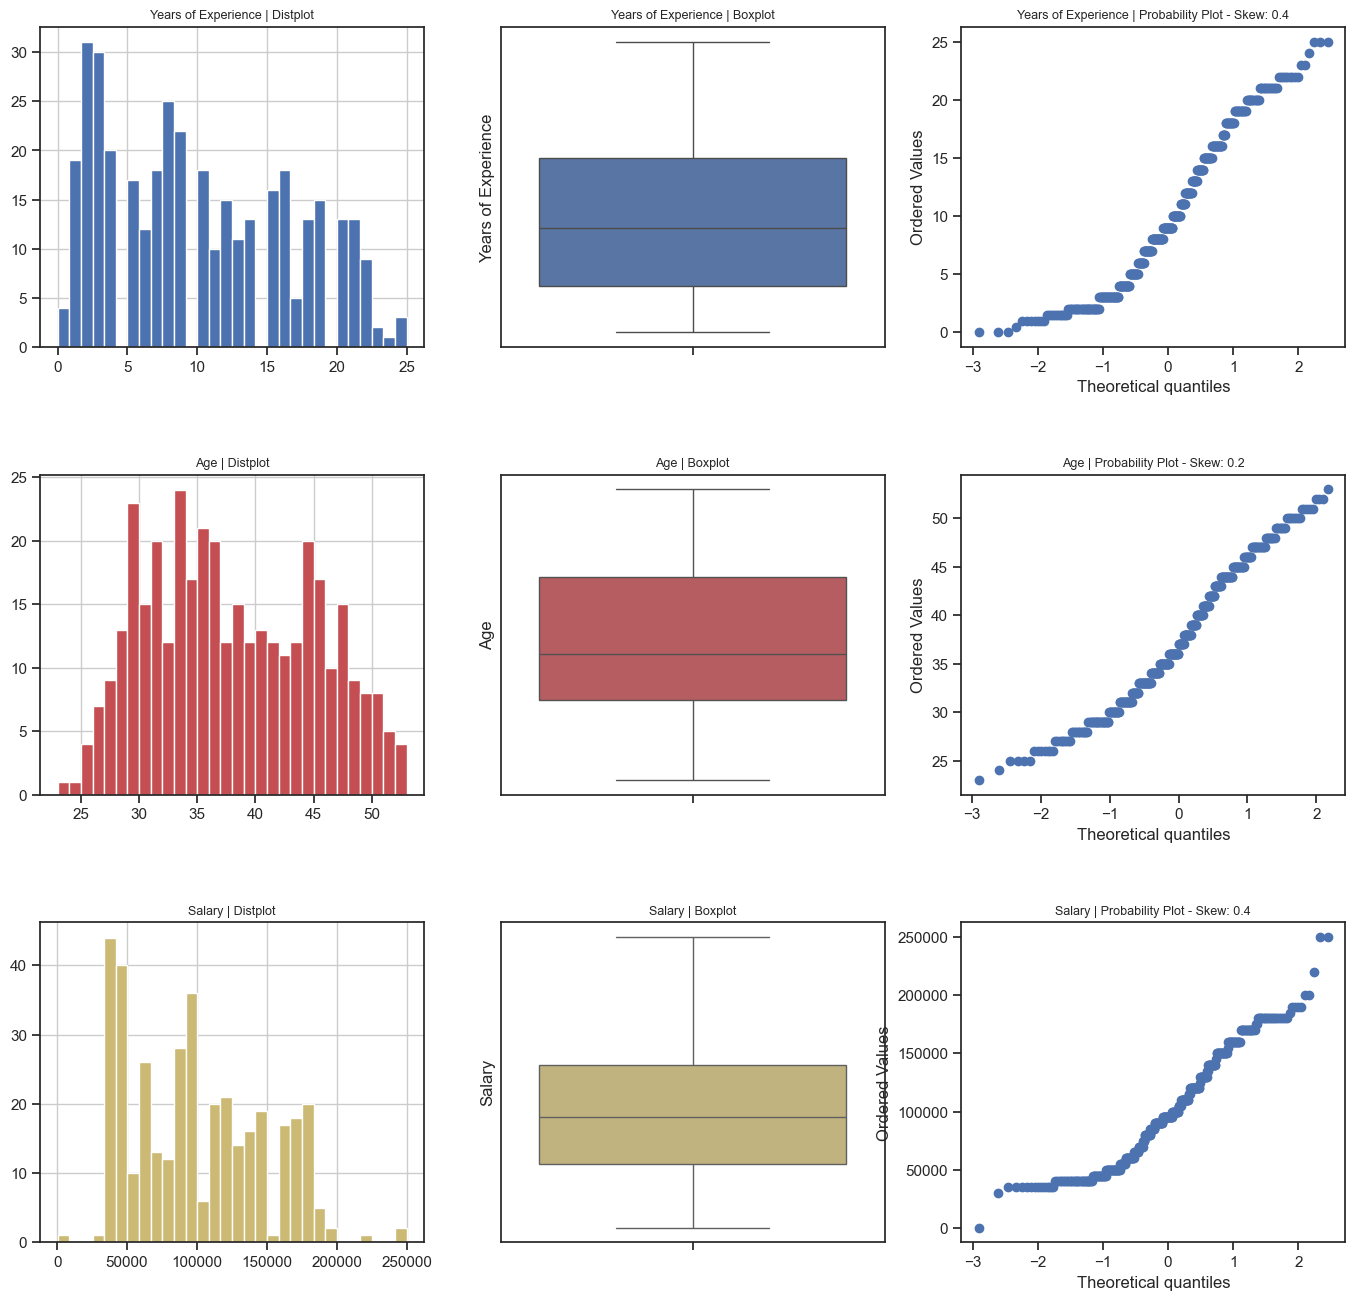

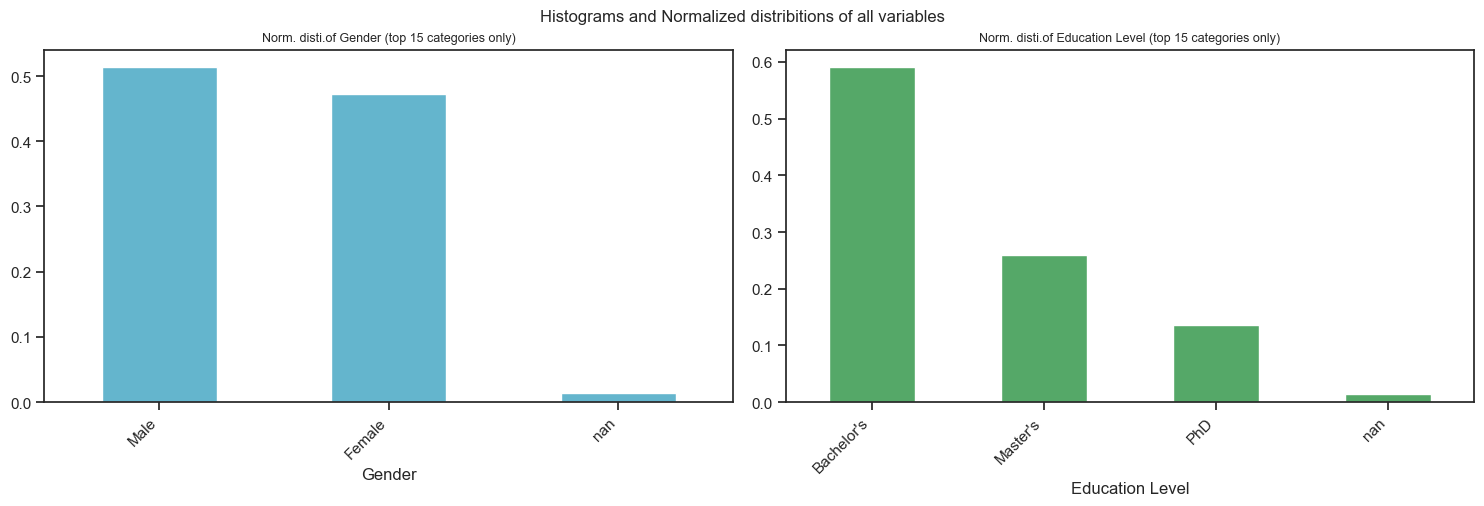

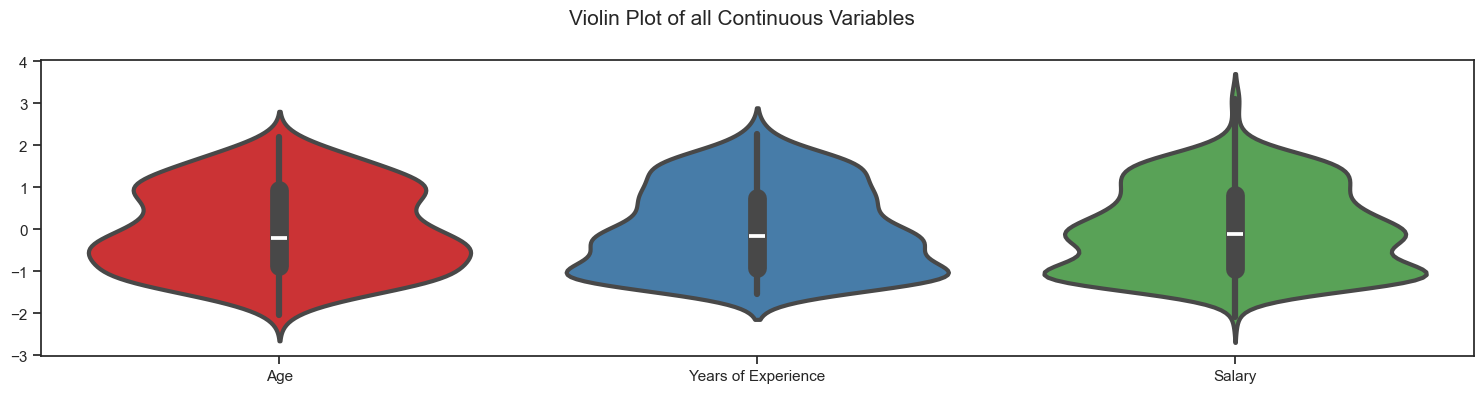

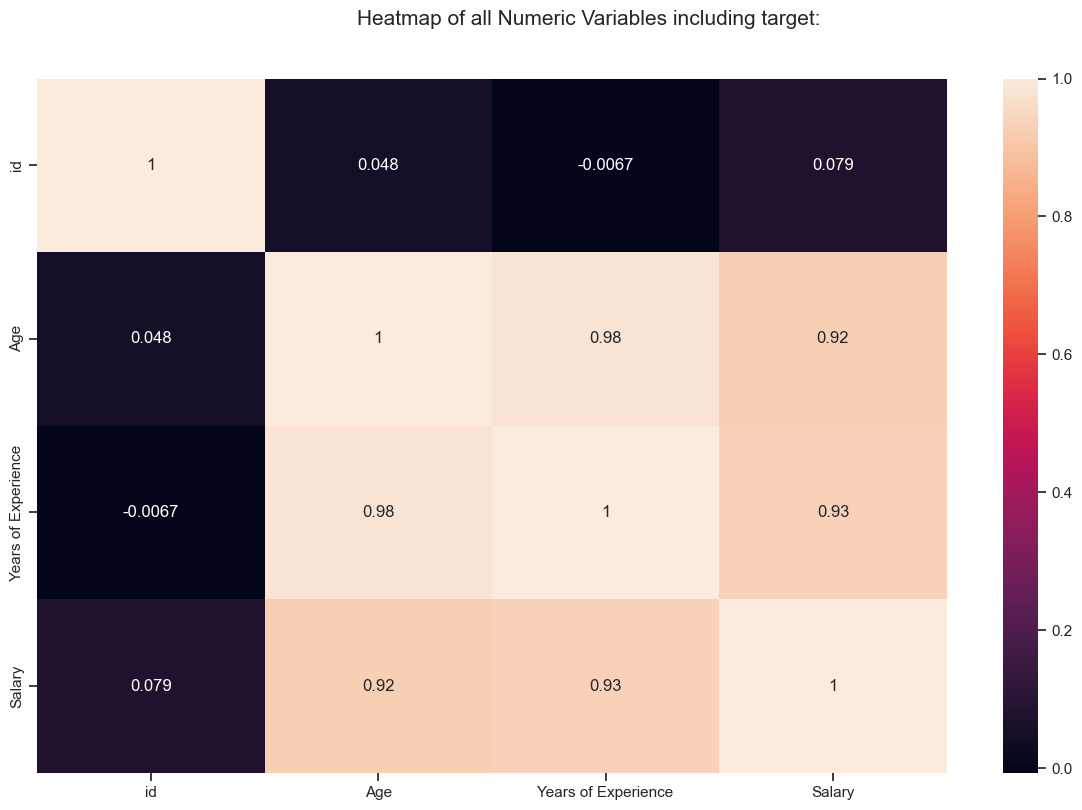

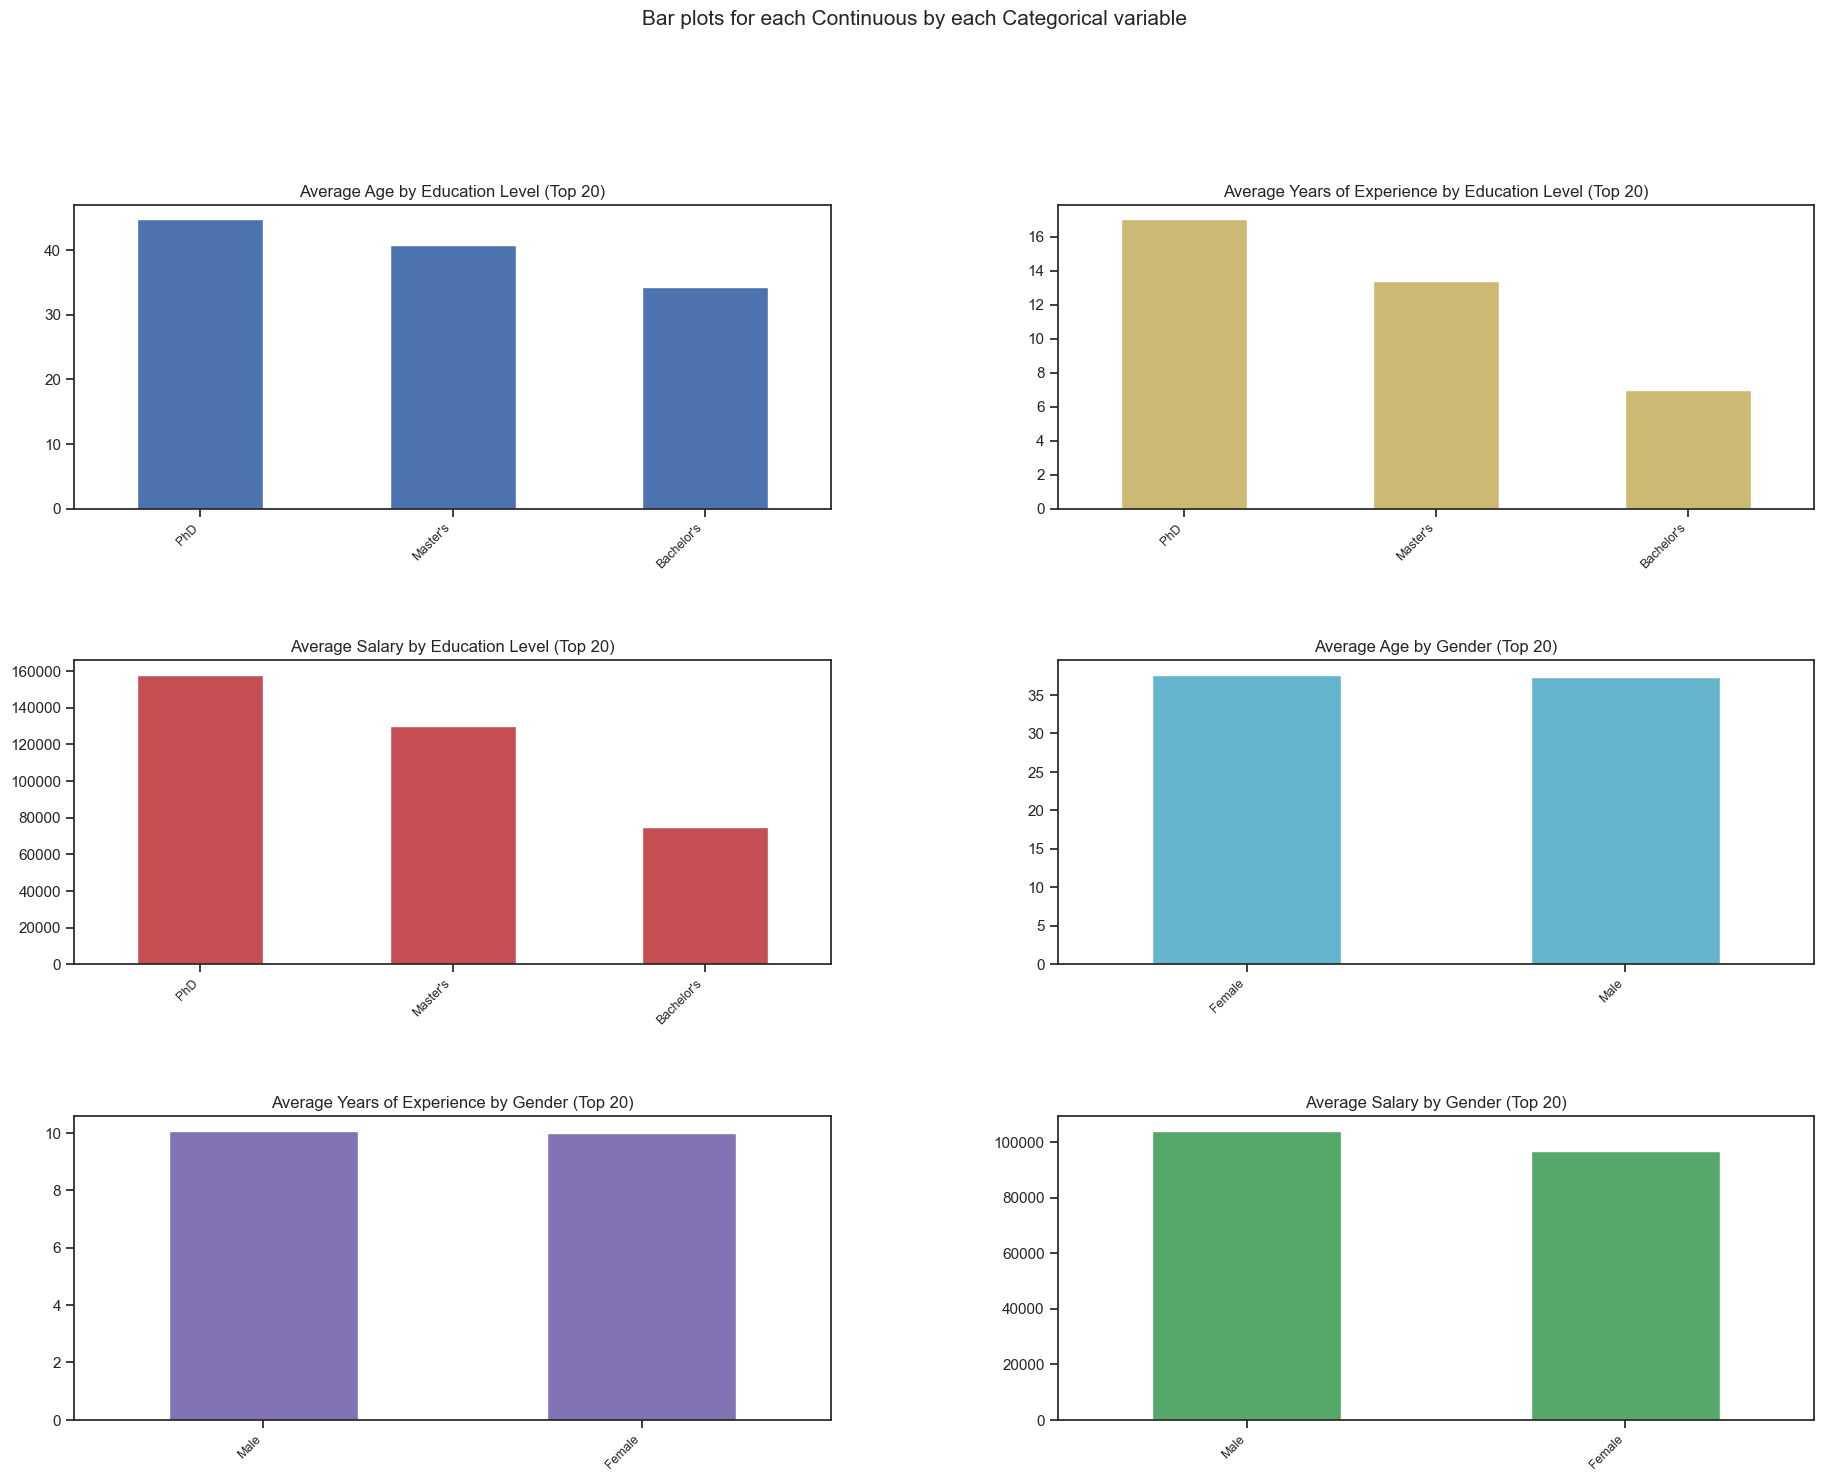

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\m_sam\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\m_sam\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\m_sam\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\m_sam\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\m_sam\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]   

Could not draw wordcloud plot for Description. 
Looks like you are missing some required data for this feature.

To download the necessary data, simply run

    python -m textblob.download_corpora

or use the NLTK downloader to download the missing data: http://nltk.org/data.html
If this doesn't fix the problem, file an issue at https://github.com/sloria/TextBlob/issues.

Could not draw wordcloud plot for Job Title. 
Looks like you are missing some required data for this feature.

To download the necessary data, simply run

    python -m textblob.download_corpora

or use the NLTK downloader to download the missing data: http://nltk.org/data.html
If this doesn't fix the problem, file an issue at https://github.com/sloria/TextBlob/issues.

All Plots done
Time to run AutoViz = 3 seconds 

 ###################### AUTO VISUALIZATION Completed ########################


[nltk_data]    |   Package punkt is already up-to-date!
[nltk_data]    | Downloading package snowball_data to
[nltk_data]    |     C:\Users\m_sam\AppData\Roaming\nltk_data...
[nltk_data]    |   Package snowball_data is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\m_sam\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | 
[nltk_data]  Done downloading collection popular


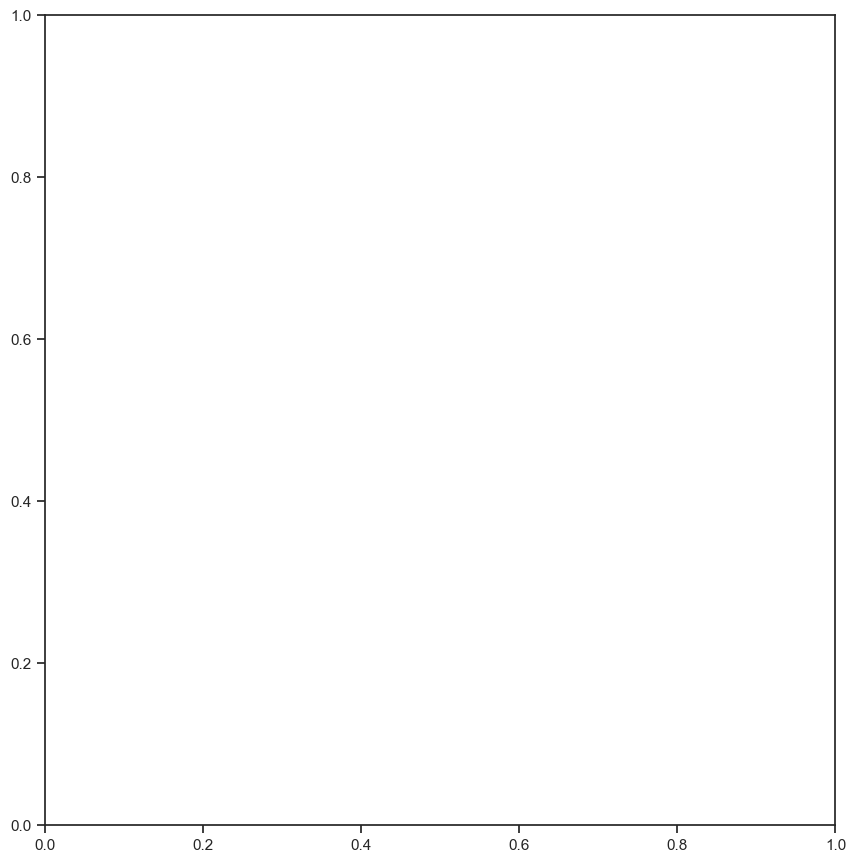

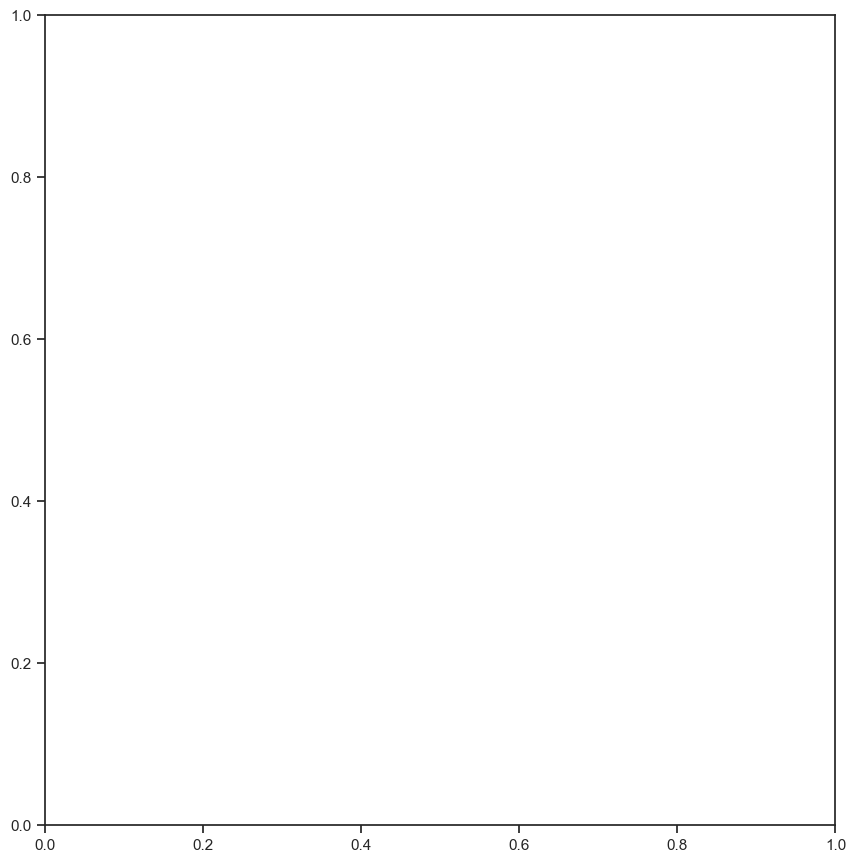

In [9]:
%matplotlib inline
df = AV.AutoViz('', dfte=merged_df)

In [10]:
import numpy as np

np.set_printoptions(suppress=True)

# En produccion eliminar, se incluye por informacion
print(f'Numpy version: {np.__version__}')

Numpy version: 1.24.4


In [11]:
import pandas as pd
#Configuración de parametros de Pandas para mejor visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3)
pd.set_option('plotting.backend', 'matplotlib') 
pd.options.mode.chained_assignment = None

# En produccion eliminar, se incluye por informacion
print(f'Pandas Version: {pd.__version__}') 

Pandas Version: 2.2.3


In [12]:
from ydata_profiling import ProfileReport
import pandas as pd

In [14]:
# Eliminar columnas del DataFrame
#columns = ['Rank']
#merged_df.drop(columns, inplace=True, axis=1)
# Generar el informe de análisis exploratorio
profile = ProfileReport(merged_df, title="Reporte de Análisis Exploratorio")

# Mostrar el informe en Jupyter Notebook (opcional)
profile.to_notebook_iframe()

# Guardar el informe como archivo HTML (opcional)
profile.to_file("reporte.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 504.02it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## SweetViz

In [18]:
import sweetviz

In [19]:
import pandas as pd
#Configuración de parametros de Pandas para mejor visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3)
pd.set_option('plotting.backend', 'matplotlib') 
pd.options.mode.chained_assignment = None

# En produccion eliminar, se incluye por informacion
print(f'Pandas Version: {pd.__version__}') 

Pandas Version: 2.2.3


In [20]:
my_report  = sweetviz.analyze(merged_df)

                                             |          | [  0%]   00:00 -> (? left)

In [21]:
my_report.show_html()
#my_report.show_html('FinalReport.html')

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
